This notebook looks through a Google Drive Folder with following structure:
```
MyDrive
└───dataset
│   └───0
│   │   ├── tongue_1.png
│   │   ├── tongue_2.png
│   │   ├── ...
│   │
│   └───1
│   │   ├── none_1.png
│   │   ├── none_2.png
│   │   ├── ...
│   │
│   └───2
│   │   ├── smile_1.png
│   │   ├── smile_2.png
│   │   ├── ...
│   │
│   └───3
│       ├── misc_1.png
│       ├── misc_2.png
│       ├── ...
│
└───testset
│   └───12in
│   │   ├── tongue_1.png
│   │   ├── none_1.png
|   |   ├── smile_1.png
|   |   ├── misc_1.png
│   │   ├── ...
│   │
│   └───24in
│   │   ├── tongue_1.png
│   │   ├── none_1.png
|   |   ├── smile_1.png
|   |   ├── misc_1.png
│   │   ├── ...
│   │
│   └───36in
│   │   ├── tongue_1.png
│   │   ├── none_1.png
|   |   ├── smile_1.png
|   |   ├── misc_1.png
│   │   ├── ...

```

dataset are images used for traing the model
testset is used to test true positives

In [1]:
!pip install -U tensorflow-addons imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow_addons as tfa
import cv2

from sklearn.model_selection import train_test_split

import imutils
from imutils import face_utils
from imutils import paths
import dlib
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

import matplotlib.pyplot as plt

import time
import sys

import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2023-05-01 17:17:45--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  47.9MB/s    in 1.3s    

2023-05-01 17:17:46 (47.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [6]:
#adding code for the dlib model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(datFile)

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

x_data = np.array([])
data = '/content/drive/MyDrive/dataset'

for i in os.listdir(data):
    print(f"#### looking in folder {i} ####")
    for imgs in os.listdir(data + '/' + i):
        if imgs.endswith(".png"):
            img = cv2.imread(data + '/' + i + '/' + imgs)
            faces = detector(img, 1)
            for (f, face) in enumerate(faces):
                landmarks = predictor(img, face)
                landmarks = face_utils.shape_to_np(landmarks)
                mouth_list = [landmarks[34], landmarks[9], landmarks[48], landmarks[54]] # sides of mouth, nose and chin for top and bottom
                mouth_list = np.array(mouth_list)
                buffer = 0
                min_x = np.min(mouth_list[:,0]) - buffer
                min_y = np.min(mouth_list[:,1]) - buffer
                max_x = np.max(mouth_list[:,0]) + buffer + 1
                max_y = np.max(mouth_list[:,1]) + buffer + 1

                im = img[ min_y:max_y, min_x:max_x]
                im = cv2.resize(im, (32, 32))
                r = im[:,:,0] #Slicing to get R data
                g = im[:,:,1] #Slicing to get G data
                b = im[:,:,2] #Slicing to get B data         

                if not len(x_data):
                    x_data = np.array([[r] + [g] + [b]],np.uint8)
                    y_data = np.array([[int(i)]])
                else:
                    curr = np.array([[r] + [g] + [b]],np.uint8)
                    x_data = np.append(x_data, curr, 0)
                    y_data = np.append(y_data, np.array([[int(i)]]))

x_data = np.transpose(x_data, (0, 2, 3, 1))
print(f'data collection complete! X: {x_data.shape} y: {y_data.shape}')

Num GPUs Available:  1
#### looking in folder 3 ####
#### looking in folder 2 ####
#### looking in folder 1 ####
#### looking in folder 0 ####
data collection complete! X: (5934, 32, 32, 3) y: (5934,)


In [8]:
num_classes = 4
input_shape = (32, 32, 3)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4747, 32, 32, 3) - y_train shape: (4747,)
x_test shape: (1187, 32, 32, 3) - y_test shape: (1187,)


In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)


In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 12 X 12
Patches per image: 36
Elements per patch: 432


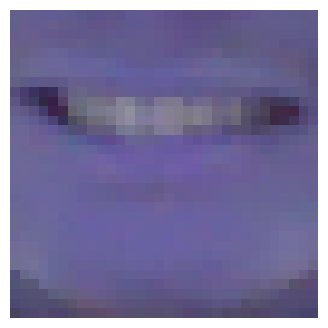

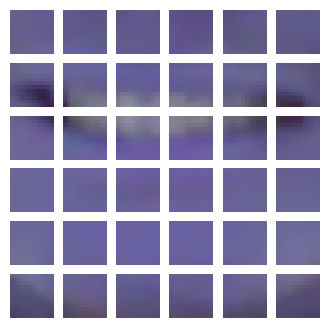

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
# image = x_train[np.random.choice(range(x_train.shape[0]))].T
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [15]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [16]:
def run_experiment(model):
#     optimizer = tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
17/17 [==============================] - 45s 272ms/step - loss: 1.1445 - accuracy: 0.7374 - top-5-accuracy: 1.0000 - val_loss: 0.2628 - val_accuracy: 0.9347 - val_top-5-accuracy: 1.0000
Epoch 2/100
17/17 [==============================] - 2s 148ms/step - loss: 0.2480 - accuracy: 0.9260 - top-5-accuracy: 1.0000 - val_loss: 0.1748 - val_accuracy: 0.9495 - val_top-5-accuracy: 1.0000
Epoch 3/100
17/17 [==============================] - 2s 133ms/step - loss: 0.1648 - accuracy: 0.9499 - top-5-accuracy: 1.0000 - val_loss: 0.1400 - val_accuracy: 0.9621 - val_top-5-accuracy: 1.0000
Epoch 4/100
17/17 [==============================] - 2s 133ms/step - loss: 0.1310 - accuracy: 0.9576 - top-5-accuracy: 1.0000 - val_loss: 0.1143 - val_accuracy: 0.9663 - val_top-5-accuracy: 1.0000
Epoch 5/100
17/17 [==============================] - 2s 150ms/step - loss: 0.1261 - accuracy: 0.9635 - top-5-accuracy: 1.0000 - val_loss: 0.0577 - val_accuracy: 0.9811 - val_top-5-accuracy: 1.0000
Epoch 6/100
17

In [17]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

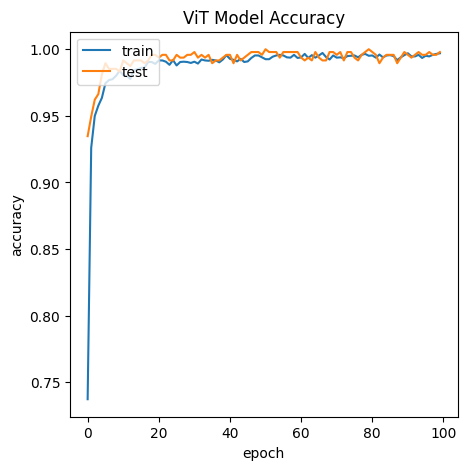

In [18]:
plt.figure(figsize=(5, 5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ViT Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.show()

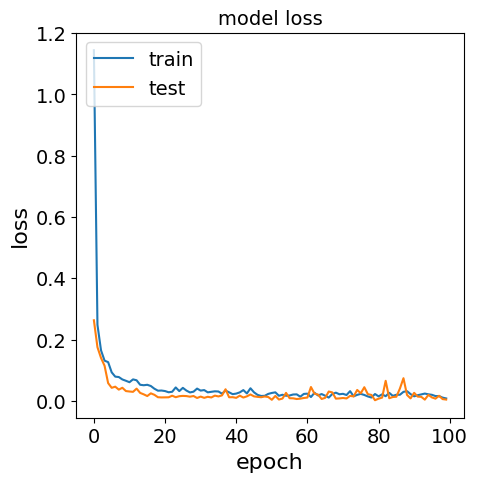

In [19]:
plt.figure(figsize=(5, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.show()

In [20]:
model = create_vit_classifier()

optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)

model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Epoch 1/100
17/17 [==============================] - 17s 345ms/step - loss: 1.3210 - accuracy: 0.7214 - top-5-accuracy: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.9011 - val_top-5-accuracy: 1.0000
Epoch 2/100
17/17 [==============================] - 3s 160ms/step - loss: 0.2691 - accuracy: 0.9202 - top-5-accuracy: 1.0000 - val_loss: 0.1196 - val_accuracy: 0.9642 - val_top-5-accuracy: 1.0000
Epoch 3/100
17/17 [==============================] - 2s 132ms/step - loss: 0.1736 - accuracy: 0.9499 - top-5-accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 0.9768 - val_top-5-accuracy: 1.0000
Epoch 4/100
17/17 [==============================] - 2s 135ms/step - loss: 0.1138 - accuracy: 0.9663 - top-5-accuracy: 1.0000 - val_loss: 0.0625 - val_accuracy: 0.9811 - val_top-5-accuracy: 1.0000
Epoch 5/100
17/17 [==============================] - 2s 134ms/step - loss: 0.1011 - accuracy: 0.9731 - top-5-accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9874 - val_top-5-accuracy: 1.0000
Epoch 6/100
17

In [21]:
import pandas as pd
import seaborn as sns

#### looking in distance 24in ####
1/1 [==============================] - 0s 31ms/step
#### looking in distance 12in ####
1/1 [==============================] - 0s 29ms/step
#### looking in distance 36in ####
1/1 [==============================] - 0s 30ms/step


<Axes: xlabel='Distance', ylabel='Count'>

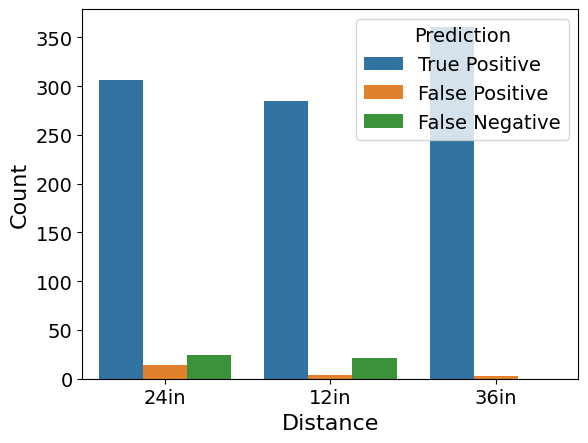

In [25]:
testset = '/content/drive/MyDrive/testset'
img_class = {'tongue': 0, 'relaxed': 1, 'smile': 2, 'misc': 3}
mouth_pose = {0: 'tongue', 1: 'relaxed', 2: 'smile', 3: 'misc'}
mouth_ls = []

# iterate through 12 24 or 36 in folders
for i in os.listdir(testset):
    print(f"#### looking in distance {i} ####")
    # imgs labelled with correct classification
    tp = 0
    fp = 0
    fn = 0
    for imgs in os.listdir(testset + '/' + i):
        if imgs.endswith(".png"):
          img_title = imgs.split('.')[0]
          img_label = img_class[img_title.split('_')[0]]
          img = cv2.imread(testset + '/' + i + '/' + imgs)
          faces = detector(img, 1)

          for (f, face) in enumerate(faces):      
            landmarks = predictor(img, face)
            landmarks = face_utils.shape_to_np(landmarks)

            # 51 middle of upper lip
            # 57 middle of lower lip
            # 48 outter left corner of the lip
            # 54 outter right corner of the lip
            
            mouth_list = [landmarks[34], landmarks[9], landmarks[48], landmarks[54]] # sides of mouth, nose and chin for top and bottom
            mouth_list = np.array(mouth_list)
            buffer = 0
            min_x = np.min(mouth_list[:,0]) - buffer
            min_y = np.min(mouth_list[:,1]) - buffer
            max_x = np.max(mouth_list[:,0]) + buffer + 1
            max_y = np.max(mouth_list[:,1]) + buffer + 1

            im = img[ min_y:max_y, min_x:max_x]
            im = cv2.resize(im, (32, 32))
            r = im[:,:,0] #Slicing to get R data
            g = im[:,:,1] #Slicing to get G data
            b = im[:,:,2] #Slicing to get B data

            curr = np.array([[r] + [g] + [b]],np.uint8)
            curr = np.transpose(curr, (0, 2, 3, 1))

            mouth = model.predict(curr)
            mouth_idx = np.argmax(mouth)
            
            is_true = None

            if mouth_idx == img_label:
              is_true = 'True Positive'
              tp += 1
            elif mouth_idx == 0 and mouth_idx != img_label:
              is_true = 'False Positive'
              fp += 1
            elif mouth_idx != 0 and img_label == 0:
              is_true = 'False Negative'
              fn += 1
    mouth_ls.append({'Distance': i, 'Count': tp, 'Prediction': 'True Positive'})
    mouth_ls.append({'Distance': i, 'Count': fp, 'Prediction': 'False Positive'})
    mouth_ls.append({'Distance': i, 'Count': fn, 'Prediction': 'False Negative'})
results =  f"./results_{time.strftime('%Y-%m-%d_%I-%M-%S')}.csv"



<Axes: xlabel='Distance', ylabel='Count'>

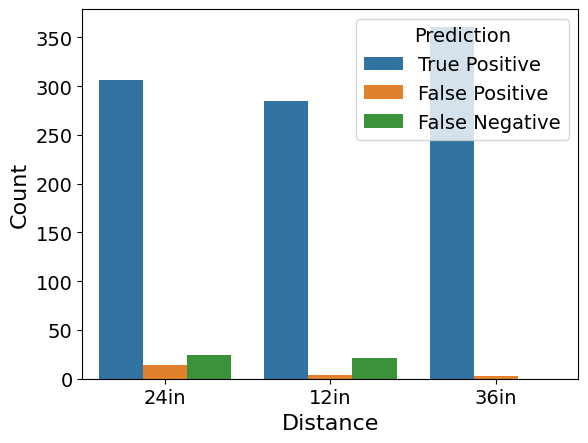

In [26]:
df = pd.DataFrame(mouth_ls)
sns.barplot(data=df, x="Distance", y="Count", hue="Prediction")

In [23]:
# !jupyter nbconvert --to html /content/drive/MyDrive/"Colab Notebooks"/"ViT_from_pics_bh_tongue_click.ipynb"